<a href="https://colab.research.google.com/github/tirthasheshpatel/Generative-Models/blob/master/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import numpy as np

def sigmoid(X):
    r"""Evaluate the sigmoid function elementwise on
    a vector or matrix X

    Parameters
    ----------
    X: array_like
        Array on which the function needs to be applied

    Returns
    -------
    sigma_X: array_like of shape `X.shape`
        Array on which sigmoid function is applied elementwise
    """
    sigma_X = 1. / (1. + np.exp(-X))
    return sigma_X

class BinaryRestrictedBoltzmannMachine(object):
    r"""A restricted boltzmann machine model that takes
    binary inputs and maps it to a binary latent space.

    Parameters
    ----------
    hidden_dims: int
        The number of hidden or latent variables in your model

    Returns
    -------
    self : object
    """

    def __init__(self, hidden_dims):
        self.hidden_dims = hidden_dims

    def _init_params(self, visible_dims):
        r"""Initialize the parameters of the model

        Parameters
        ----------
        visible_dims: int
            The number of visible dimentations.
        
        Returns
        -------
        None
        """
        self.visible_dims = visible_dims

        m = self.visible_dims
        n = self.hidden_dims

        self.W = np.random.randn(m, n)
        self.b = np.random.randn(m, 1)
        self.c = np.random.randn(n, 1)

        return None

    def __gibbs_step(self, V_t):
        r"""Take one gibbs sampling step.

        Parameters
        ----------
        V_t: array_like
            The values of the visible variables at time step `t`.

        Returns
        -------
        V_tplus1: array_like
            The value of variables at time step `t+1`.
        """
        # We will first sample the hidden variables using
        # P(H_t | V_t) => probability of observing H given V at time step t.
        # P(V_tplus1 | H_t) => Sample new visible varaibles at time step t+1.
        probs_H = sigmoid(self.W.T @ V_t + self.c)

        # One more thing, this is called "block" gibb's
        # sampling where we vectorize over all dimensions
        # and sample from all the dimensions at the same time.
        H_t = 1. * (np.random.rand(*probs_H.shape) <= probs_H)

        probs_V = sigmoid(self.W @ H_t + self.b)
        V_tplus1 = 1. * (np.random.rand(*probs_V.shape) <= probs_V)

        return V_tplus1

    def _gibbs_sampling(self, V_0, burn_in, tune):
        r"""The gibb's sampling step in training to calculate
        the estimates of the expectation in the gradient.

        Parameters
        ----------
        V_0: array_like
            The visible variables at time step 0.

        burn_in: int
            The number of samples to disregard from
            the chain.

        tune: int
            The number of samples to use to estimate
            the actual expectation

        Returns
        -------
        expectation_w, expectation_b, expectation_c: array_like
            The expecation term appearing in the gradients wrt W, b and c
            respectively.
        """
        m = self.visible_dims
        n = self.hidden_dims

        # We start sampling from the markov chain.
        V_sampled = self.__gibbs_step(V_0)

        # This for loop just "warms up" the chain to reach
        # its stationary distribution. Please try to keep
        # these steps as large as possible to converge to
        # the desired distribution!
        for _ in range(burn_in):
            V_sampled = self.__gibbs_step(V_sampled)

        # The chain has now reached its stationary distribution
        # and we can start collecting the samples and estimate
        # required estimations.
        expectation_b = np.sum(V_sampled,
                               axis=-1,
                               keepdims=True)
        expectation_c = np.sum(sigmoid(self.W.T @ V_sampled + self.c),
                               axis=-1,
                               keepdims=True)
        expectation_w = V_sampled @ sigmoid(self.W.T @ V_sampled + self.c).T

        # Collect a `tune` number of samples and find the
        # sum over them. We will normalize it with `tune`
        # later on...
        for i in range(tune):
            V_sampled = self.__gibbs_step(V_sampled)

            expectation_b += np.sum(V_sampled,
                                    axis=-1,
                                    keepdims=True)
            expectation_c += np.sum(sigmoid(self.W.T @ V_sampled + self.c),
                                    axis=-1,
                                    keepdims=True)
            expectation_w += V_sampled @ sigmoid(self.W.T @ V_sampled + self.c).T

        # Finally, we have to devide by the number of samples
        # we have drawn to calculate the expectation
        return (
            expectation_w / float(tune),
            expectation_b / float(tune),
            expectation_c / float(tune)
        )

    def _contrastive_divergence(self, V_0, burn_in, tune):
        r"""Train using contrastive divergence method

        Parameters
        ----------
        V_0: array_like
            A training sample
        
        burn_in: int
            Present for API consistency.
        
        tune: int
            `k` term in `k-contrastive-divergence` algorithm.
        
        Returns
        -------
        expectation_w, expectation_b, expectation_c: array_like
            The expecation term appearing in the gradients wrt W, b and c
            respectively.
        """
        V_tilt = V_0
        for _ in range(tune):
            V_tilt = self.__gibbs_step(V_tilt)

        expectation_b = np.sum(V_tilt,
                               axis=-1,
                               keepdims=True)
        expectation_c = np.sum(sigmoid(self.W.T @ V_tilt + self.c),
                               axis=-1,
                               keepdims=True)
        expectation_w = V_tilt @ sigmoid(self.W.T @ V_tilt + self.c).T
        return expectation_w, expectation_b, expectation_c

    def _param_grads(self, V, expectation_w, expectation_b, expectation_c):
        r"""Calculate the emperical estimates of the gradients of the energy
        function with respect to [W, b, c].

        Parameters
        ----------
        V: array_like
            Visible variables/data.
        
        expectation_w: array_like
            Expectation term in the equation for gradient wrt W.
        
        expectation_b: array_like
            Expectation term in the equation for gradient wrt b.

        expectation_c: array_like
            Expectation term in the equation for gradient wrt c.

        Returns
        -------
        dloss_dW, dloss_db, dloss_dc: tuple
            Gradients wrt all the parameters in the order [W, b, c].
        """
        dloss_dW = V @ sigmoid(self.W.T @ V + self.c).T - expectation_w
        dloss_db = np.sum(V, axis=-1, keepdims=True) - expectation_b
        dloss_dc = np.sum(sigmoid(self.W.T @ V + self.c), axis=-1, keepdims=True) - expectation_c

        return dloss_dW, dloss_db, dloss_dc

    def _apply_grads(self, lr, dloss_dW, dloss_db, dloss_dc):
        """Update the parameters [W, b, c] of the model using
        stochastic gradient descent.

        Parameters
        ----------
        lr: int
            Learning rate of the model
        
        dloss_dW: array_like
            The gradient of energy function wrt W.

        dloss_db: array_like
            The gradient of energy function wrt b.

        dloss_dc: array_like
            The gradient of energy function wrt c.
        
        Returns
        -------
        None
        """
        # Remember we are perfoming gradient ASSCENT (not descent)
        # to MAXIMIZE (not minimize) the energy function!
        self.W = self.W + lr * dloss_dW / self.num_examples
        self.b = self.b + lr * dloss_db / self.num_examples
        self.c = self.c + lr * dloss_dc / self.num_examples

    def fit(self, X, lr=0.1, epochs=10, method="contrastive_divergence", burn_in=1000, tune=2000, verbose=False):
        r"""Train the model on provided data

        Parameters
        ----------
        X: array_like
            The data array of shape (n_samples, n_features)
        
        lr: float, optional
            The learning rate of the model. Defaults to 0.1

        epochs: int, optional
            The number of steps to train your model
        
        method: string, optional
            Can be either "gitbbs_sampling" or "constrastive_divergence".
            Defaults to "constrastive_divergence"

        burn_in: int, optional
            The number of steps to warm the markov chain up

        tune: int, optional
            The number of samples to generate from the merkov chain
        
        verbose: bool, optional
            Weather to log the epochs or not.
        """
        # We want to vectorize over multiple batches
        # and so we have to reshape our data to `(n_features, n_samples)`
        X = X.T
        self.num_examples = X.shape[1]
        self.visible_dims = X.shape[0]

        m = self.visible_dims
        n = self.hidden_dims

        # Initialize the parameters [W, b, c] of our model
        self._init_params(m)

        # Run the training for provided number of epochs
        for _ in range(epochs):
            # Emperically calculate the expectation using our markov chain.
            if method == "gibbs_sampling":
                _method = self._gibbs_sampling
            elif method == "contrastive_divergence":
                _method = self._contrastive_divergence
            else:
                raise ValueError(f"invalid method: {method}. You sholud inherit this "
                                 f"class and implement the method with an `_` at"
                                 f"the start to use it instead of built-in methods.")

            V_0 = X
            Ew, Eb, Ec = _method(V_0, burn_in=burn_in, tune=tune)

            # Using the emperical estimates of the expectation, calculate
            # the gradients wrt all our parameters
            dloss_dW, dloss_db, dloss_dc = self._param_grads(X, Ew, Eb, Ec)

            # Update the parameters
            self._apply_grads(lr, dloss_dW, dloss_db, dloss_dc)

            if verbose:
                sys.stdout.write(f"\rEpoch {_+1}")

        return self

    def decode(self, H=None, return_proba=False):
        """Move from latent space to data space. Acts like a generator.

        Parameters
        ----------
        H: array_like, optional
            A vector of latent/hidden variables. If `None`, then it is
            randomly initialized

        Returns
        -------
        decoded: array_like
            The generated data from given latent space
        """
        # We generate a random latent space if not given
        if H is None:
            H = 1. * (np.random.rand(self.hidden_dims, 1) >= 0.5)

        # We sample the Vs given Hs.
        probs_V = sigmoid(self.W @ H + self.b)
        if return_proba:
            return probs_V
        return 1. * (np.random.rand(*probs_V.shape) <= probs_V)

    def encode(self, V):
        """Encode the given data in its latent variables.

        Parameters
        ----------
        V: array_like
            The data to be encoded

        Returns
        -------
        encoded: array_like
            An encoded vector of the given data
        """
        # We will sampe a random H for a given V.
        probs_H = sigmoid(self.W.T @ V + self.c)
        return 1. * (np.random.rand(*probs_H.shape) <= probs_H)

    def generate_smooth(self):
        """Generate a continuous input space.

        Returns
        -------
        generated: array-like
            An array of generated input space.
        """
        return self.decode(return_proba=True)

Using TensorFlow backend.


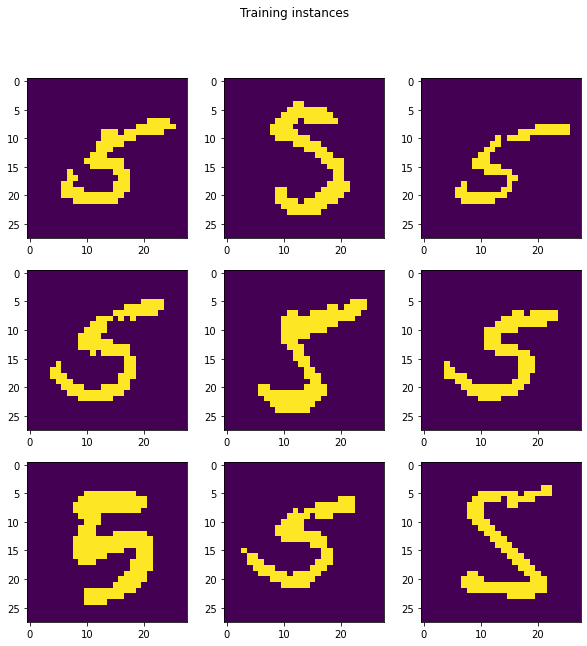

Epoch 100

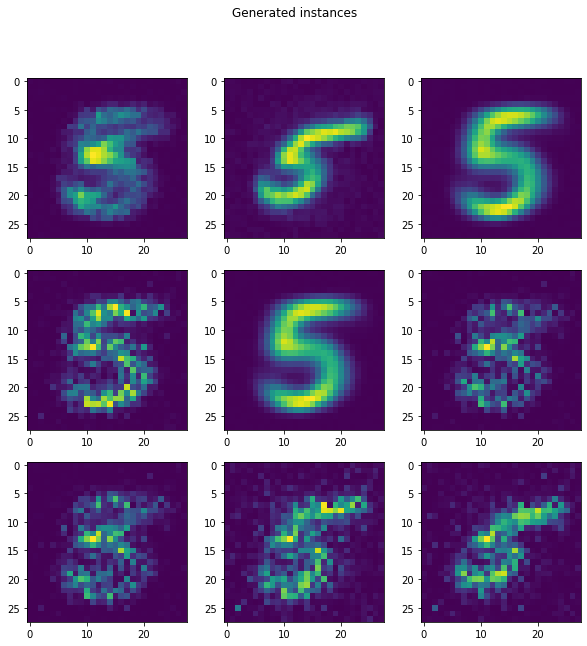

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(X_train, y), (_, _) = mnist.load_data()

# Normalize and reshape
X_train = X_train.reshape(60000, -1)
X_train = 1. * ((X_train[y == 5] / 255.) >= 0.5)

# Plot some training isntances
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
ax[0, 0].imshow(X_train[10].reshape(28, 28))
ax[0, 1].imshow(X_train[11].reshape(28, 28))
ax[0, 2].imshow(X_train[12].reshape(28, 28))
ax[1, 0].imshow(X_train[13].reshape(28, 28))
ax[1, 1].imshow(X_train[14].reshape(28, 28))
ax[1, 2].imshow(X_train[15].reshape(28, 28))
ax[2, 0].imshow(X_train[16].reshape(28, 28))
ax[2, 1].imshow(X_train[17].reshape(28, 28))
ax[2, 2].imshow(X_train[18].reshape(28, 28))
fig.suptitle("Training instances")
plt.show()

# We will mainly experiment with different latent space
# dimensions. For this instance, i have a 30-D latent space.
hidden_dims = 3

# Define our model
model = BinaryRestrictedBoltzmannMachine(hidden_dims)

# Train the model on our dataset with learning rate 1.0
model.fit(X_train, lr=1.0, burn_in=None, tune=1, epochs=100, verbose=True)

# Use the `decode()` method to generate an image.
images = [model.generate_smooth() for _ in range(9)]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
ax[0, 0].imshow(images[0].reshape(28, 28))
ax[0, 1].imshow(images[1].reshape(28, 28))
ax[0, 2].imshow(images[2].reshape(28, 28))
ax[1, 0].imshow(images[3].reshape(28, 28))
ax[1, 1].imshow(images[4].reshape(28, 28))
ax[1, 2].imshow(images[5].reshape(28, 28))
ax[2, 0].imshow(images[6].reshape(28, 28))
ax[2, 1].imshow(images[7].reshape(28, 28))
ax[2, 2].imshow(images[8].reshape(28, 28))
fig.suptitle("Generated instances")
plt.show()

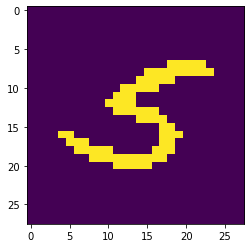

In [7]:
plt.imshow(X_train[34].reshape(28, 28))

In [0]:
encoded = model.encode(X_train[34].reshape(-1, 1))

In [5]:
encoded.shape

(3, 1)

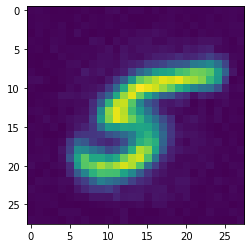

In [6]:
decoded = model.decode(encoded, return_proba=True)
plt.imshow(decoded.reshape(28, 28))